<a href="https://colab.research.google.com/github/Alexflames/frame-detection/blob/master/Unet_frame_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Автор
Григорьев Алексей, 451 группа, КНиИТ

## Задание
С помощью машинного обучения научиться различать рамки у картин для последующего вырезания и превращения изображений картин с рамками в картины **без** рамок

### Часть 2 - решение с использованием Unet
##### **"Простой" набор данных**
[Первый набор данных](https://drive.google.com/open?id=19Wx9l9C6IovJ5n1OTYzmt39w5cmIgzHJ) представляет 200 "простых для обработки" изображений картин с рамками,
собраны в поисковике google, посредством отфильтрации подходящих вручную.
- **Все** картины имеют рамки;
- Картины **не** повернуты под углом;
- Может быть свободное пространство любого цвета **до** рамки, **после** рамки перед изображением;
- Рамки преимущественно монотонные, но также иногда встречаются объмные варианты;
- Возможно наличие теней или других эффектов окружающего мира на центральной части изображения / с какой-то стороны от картины;
- Форматы изображений `.jpg | .png | .webp`;
- Изображения разных размеров, разное соотношение сторон;
- Различная цветовая гамма.

##### **Материал**
- [Использование Unet для решения своей задачи](https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623)
- [Гит-репозитории в Google Colab](https://medium.com/@ashwindesilva/how-to-use-google-colaboratory-to-clone-a-github-repository-e07cf8d3d22b)
- [Оригинальный репозиторий с Unet](https://github.com/zhixuhao/unet)
- [Подходящая версия под первую статью](https://github.com/zhixuhao/unet/commit/4b939a4dbd930eeaf3d6fffcb514860cb11c948d)

##### **Программа**
Далее следуют фрагменты программы для решения задачи



**Шаг №1**

Подключаем гугл-диск, клонируем мой форк оригинального Unet-репозитория
Форк необходим так как код немного модифицирован, ветка frame-detection создана из коммита *4b939a4dbd930eeaf3d6fffcb514860cb11c948d*

In [4]:
from google.colab import drive
print("Если код выводит ошибки типа [Errno 2], игнорируйте их. Эти ошибки не мешают выполнению программы\n")
drive.mount('/content/gdrive')
! ls
# Замените путь после 'My Drive' на ваш собственный путь с проектом и данными
%cd gdrive/My Drive/Studies2/ML
# следующий фрагмент необходимо использовать только 1 раз!!!
#! git clone https://github.com/Alexflames/unet.git
%cd unet
! git pull
! git checkout frame-detection
! git branch

Если код выводит ошибки типа [Errno 2], игнорируйте их. Эти ошибки не мешают выполнению программы

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data  data.py  img  README.md  split_merge_tif.py  test_predict.py  unet.py
[Errno 2] No such file or directory: 'gdrive/My Drive/Studies2/ML'
/content/gdrive/My Drive/Studies2/ML/unet
[Errno 2] No such file or directory: 'unet'
/content/gdrive/My Drive/Studies2/ML/unet
Already up to date.
Already on 'frame-detection'
Your branch is up to date with 'origin/frame-detection'.
* frame-detection
  master


In [0]:
# Можно раскомментировать и запустить чтобы посмотреть структуру проекта 
# !ls

In [0]:
# Можно раскомментировать и запустить чтобы посмотреть структуру проекта 
# !ls pictureset_simple_1

Возьмем X изображений из папки `pictureset_simple_1` и выведем на экран

In [0]:
import os
filenames = []
for filename in os.listdir(folder_name):
  filenames.append(os.path.join(folder_name, filename))

Выборка X изображений.

Смените флаг `show_images` на True чтобы вывести выбранные изображения на экран

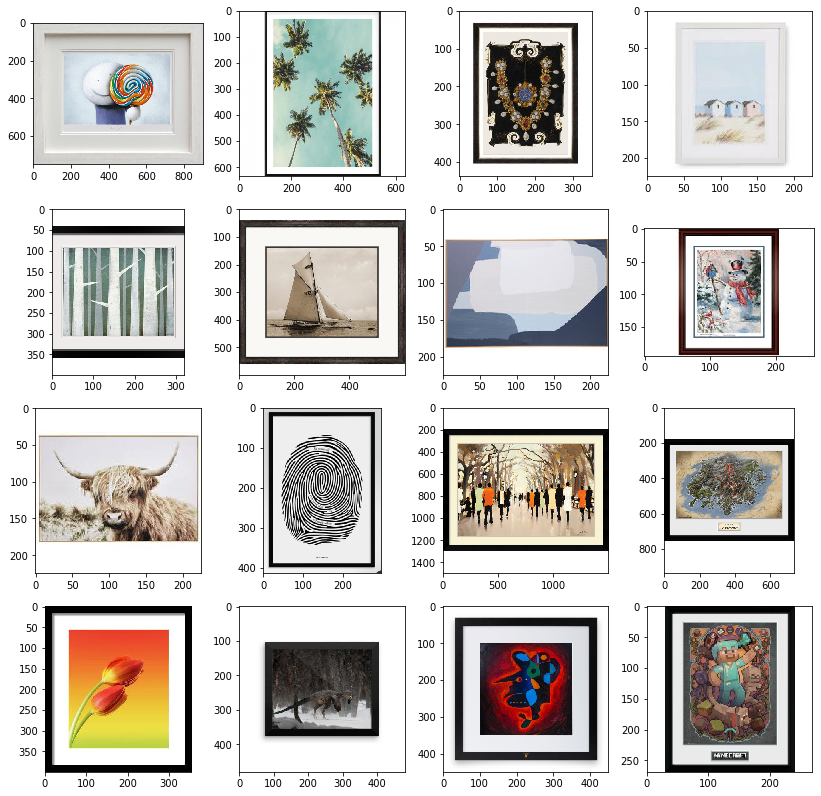

In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

X_images = 16

random_index = np.random.choice(range(len(filenames)), X_images)
chosen_pictures = []

for i_normal, index in enumerate(random_index):
  img_picked = cv2.imread(filenames[index])
  chosen_pictures.append(img_picked)

# Блок вывода изображений на экран
test_show_images = True

def nearest_square(limit):
    answer = 0
    while (answer+1)**2 < limit:
        answer += 1
    return (answer + 2)

def show_images(cv_images):
  X_nearest_square = nearest_square(X_images) - 1 # расположим X фигур в квадрате
  fig, axeslist = plt.subplots(ncols = X_nearest_square, nrows = X_nearest_square)
  
  for i in range(len(cv_images)):
    img_picked = cv_images[i]
    axeslist.ravel()[i].imshow(img_picked[:, :, ::-1]) # показ переведенного из BGR в RGB изображения
    #axeslist.ravel()[i].set_axis_off()
  
  plt.rcParams["figure.figsize"] = (14,14)
  plt.show()

if test_show_images:
  show_images(chosen_pictures)

С помощью средств OpenCV найдем рамки изображения, переведя Grayscale версию в ч/б с помощью функции `threshold`. Найденные контуры обрабатываются функцией `boundingRect` чтобы найти прямоугольник описывающий контур. К прямоугольнику предъявляются следующие условия:
- Его размер должен быть больше `size_threshold`
- Его центр должен быть удален от центра изображения не более чем на `eps_centre`

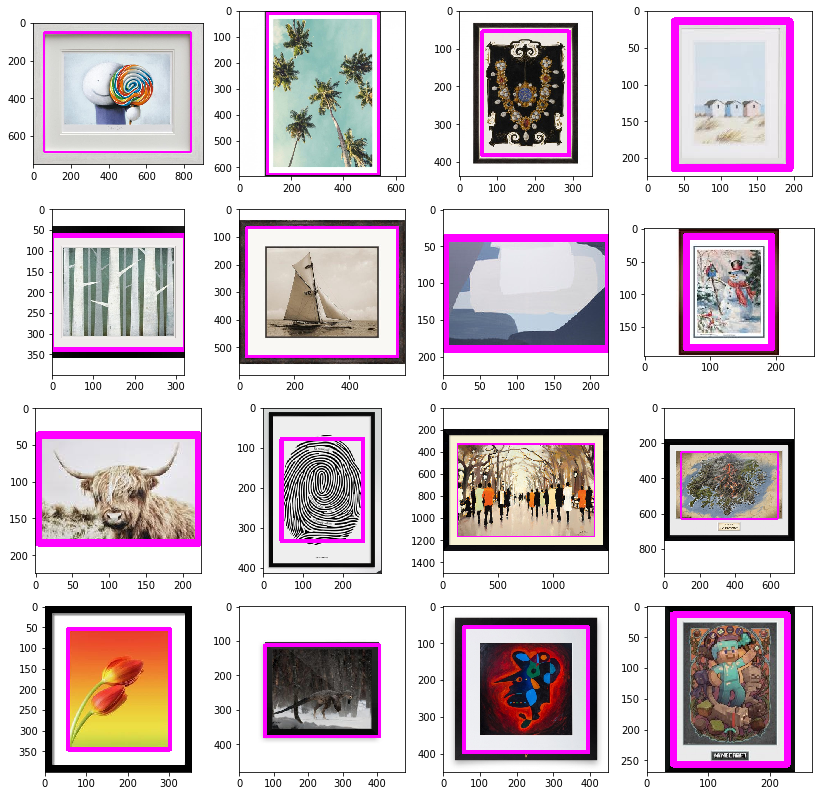

In [0]:
import cv2
import numpy as np

# Сортировка контуров по их длине
def sort_by_perimter(contour):
  return cv2.arcLength(contour, True)

def image_threshold(img, threshold):
  ret,thresh = cv2.threshold(img, threshold, 255, 0)  # все что ниже границы становится черным, выше - белым
  return thresh

# Вариант с уменьшением количества серых цветов до colors_count, результат плохой
# и работает медленно
def image_lower_colors(img, colors_count):
  img_1d = np.ravel(img)
  multiplier = 255 // colors_count
  for i in range(len(img_1d)):
    img_1d[i] = (img_1d[i] // multiplier) * multiplier
  return img 

# Функция, подбирающая ч/б границу цвета в цикле от a до b с шагом h
# Возвращает openCV контуры для разных threshold в обычном списке
def vary_threshold_contours(img, a, b, h):
  contours_return = []
  for threshold in range(a, b, h):
    img_filtered = image_threshold(img, threshold)
    _, contours, _ = cv2.findContours(img_filtered, 1, 2) # находим контуры
    if len(contours_return) == 0 and len(np.shape(contours)) == 1:
      contours_return = np.copy(contours)
    elif len(np.shape(contours)) == 1:
      contours_return = np.concatenate((contours_return, contours))
      #print(threshold, np.shape(contours_return), np.shape(contours))
  return contours_return.tolist()

# магические константы, с помощью которых можно колдовать над результатом
# минимальный размер содержимого во всей картинке
size_threshold = 0.4 ** 2
# возможное смещение содержимого от центра
eps_centre = 0.03
# подбор ч/б границ для функции `vary_threshold_contours`
thresh_a, thresh_b, thresh_h = 30, 241, 30 

def estimated_frames(img):
  imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  #_, contours, _ = cv2.findContours(img_filtered, 2, 2) # находим контуры
  contours = vary_threshold_contours(imgGray, thresh_a, thresh_b, thresh_h)

  contours.sort(key=sort_by_perimter, reverse=True)

  img_height = img.shape[0]
  img_width = img.shape[1]
  img_square = img_width * img_height
  
  boxes = []
  for cnt in contours:
    # ищем прямоугольник, описывающий контур
    x,y,w,h = cv2.boundingRect(cnt) # находим неповернутый прямоугольник, описывающий контур

    # проверка размера изображения (так как отсортированы, то можно полагать что все последующие не подходят)
    if w * h < img_square * size_threshold:
      #print("size limit exceeded:", w * h, img_square * size_threshold)
      break

    # проверка центрированности, допускается отклонение на epsilon от ширины и высоты
    cnt_center = (x + w/2, y + h/2)
    #print(abs(cnt_center[1] - img_width / 2), abs(cnt_center[0] - img_height / 2))
    if abs(cnt_center[0] - img_width / 2) > eps_centre * img_width  or abs(cnt_center[1] - img_height / 2) > eps_centre * img_height:
      #print(cnt_center)
      continue  

    # преобразуем из (x y w h) в numpy array точек
    box = np.array([np.array([x, y]), np.array([x+w, y]), np.array([x+w, y+h]), np.array([x, y+h])])      
    box = np.int0(box) # так делают в интернете, переводят в целые числа
    boxes.append(box)

  return boxes

def img_with_contour(img):
  frames = estimated_frames(img)
  if len(frames) > 0:
    cv2.drawContours(img, [frames[-1]], 0, (255, 0, 255), 10)
  return img

images_contoured = []
for i in range(len(chosen_pictures)):
  image_proceed = chosen_pictures[i].copy()
  images_contoured.append(img_with_contour(image_proceed))
show_images(images_contoured)

### Архив
Содержит старые функции, которые показали худший результат по сравнению с актуальным. Решил не удалять код на всякий случай.

In [0]:
def img_with_contour1887(img):
  imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(imgGray, 200, 255, 0)  # все что ниже границы становится черным, выше - белым
  _, contours, _ = cv2.findContours(thresh, 1, 2) # находим контуры

  contours.sort(key=sort_by_perimter, reverse=True)
  n = 3
  cnts = contours[0:n] # выбираем первые n контуров
  for cnt in cnts:
    cv2.drawContours(img, [cnt], 0, (0, 0, 255), 3)
    # вариант 1 - но он ищет не минимум, вообще-то минимум но у меня почему-то нет
    x,y,w,h = cv2.boundingRect(cnt) # находим неповернутый прямоугольник, описывающий контур
    # преобразуем из (x y w h) в формат, принимаемый функцией отрисовки
    box = np.array([np.array([x, y]), np.array([x+w, y]), np.array([x+w, y+h]), np.array([x, y+h])])      
    cv2.drawContours(img, [box], 0, (0, 255, 0), 3)           

    # вариант 2 - возвращает минимальные но повернутые прямоугольники 
    # 2 точки в одномерном массиве, нужно в двумерном
    rect = cv2.minAreaRect(cnt) # находим прямоугольник (может повернутый), описывающий контур
    box = cv2.boxPoints(rect) # находим 4 вершины прямоугольника
    box = np.int0(box) # так делают в интернете, переводят в целые числа
    # принимает формат [[x1 y1] [x2 y2] [x3 y3] [x4 y4]]
    if (len([box]) > 0):
      cv2.drawContours(img, [box], 0, (255, 0, 255), 3)

  return img